In [1]:
import numpy as np
import glob
import re

from aicsimageio import AICSImage, readers
from pathlib import Path
from matplotlib import pyplot as plt

from blimp.preprocessing.illumination_correction import IlluminationCorrection

25-Jul-24 13:55:28 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


# Correct illumination

Search images of the correct channel in the input directories

In [2]:
images_dir_1 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/240628_ARMC5_EU/Cycle2_EU/20240701_175159_151/OME-TIFF-MIP")
images_dir_2 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/240705_ARMC5_EU/Cycle2_EU/20240708_171627_050/OME-TIFF-MIP")
images_dir_3 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/240713_ARMC5_EU/Cycle2_EU/20240715_173604_562/OME-TIFF-MIP")
image_files_1 = glob.glob(str(images_dir_1 / "*.tiff"))
image_files_2 = glob.glob(str(images_dir_2 / "*.tiff"))
image_files_3 = glob.glob(str(images_dir_2 / "*.tiff"))

Bright dust in images can be detrimental for calculation of a standard deviation for illumination correction. We check that all images are within the same intensity range

In [3]:
def find_outlier_indices(image_files):
    n_channels = AICSImage(image_files[0],reader=readers.ome_tiff_reader.OmeTiffReader).dims.C
    image_std = np.stack(
        [[np.std(a=AICSImage(image_file,reader=readers.ome_tiff_reader.OmeTiffReader).get_image_data('YX',C=c)) for c in range(n_channels)] for image_file in image_files]
    )
    image_std_p25 = np.percentile(image_std,25,axis=0)
    image_std_p75 = np.percentile(image_std,75,axis=0)
    image_std_iqr = image_std_p75 - image_std_p25
    upper_limit = image_std_p75 + 1.5*image_std_iqr
    outlier = image_std > upper_limit
    outlier_indices = np.argwhere(outlier[:,0:2])[:,0]
    return outlier_indices, image_std

In [4]:
%%time
outlier_indices_1, image_std_1 = find_outlier_indices(image_files_1)
reference_image_files_1 = np.delete(image_files_1,outlier_indices_1)

CPU times: user 59.3 s, sys: 6.34 s, total: 1min 5s
Wall time: 55.4 s


In [5]:
%%time
outlier_indices_2, image_std_2 = find_outlier_indices(image_files_2)
reference_image_files_2 = np.delete(image_files_2,outlier_indices_2)

CPU times: user 58.8 s, sys: 6.28 s, total: 1min 5s
Wall time: 55.1 s


In [6]:
%%time
outlier_indices_3, image_std_3 = find_outlier_indices(image_files_3)
reference_image_files_3 = np.delete(image_files_3,outlier_indices_3)

CPU times: user 58.5 s, sys: 6.43 s, total: 1min 4s
Wall time: 1min


In [7]:
image_files = image_files_1 + image_files_2 + image_files_3
reference_image_files = reference_image_files_1.tolist() + reference_image_files_2.tolist() + reference_image_files_3.tolist()

In [8]:
len(image_files)

648

In [9]:
len(reference_image_files)

618

Fit a ``blimp.IlluminationCorrection`` object

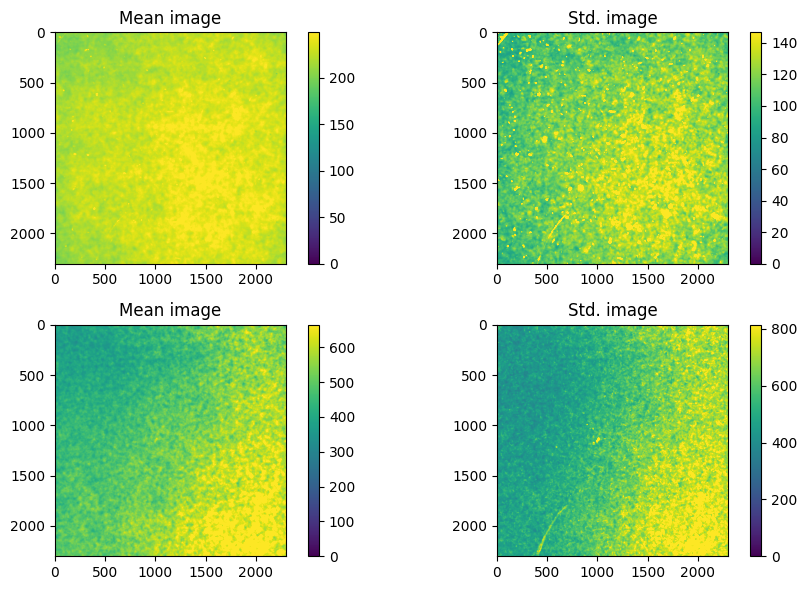

In [10]:
illumination_correction = IlluminationCorrection(
    reference_images=reference_image_files,
    timelapse=False,
)
illumination_correction.plot()

# Save illumination correction object to disk

The ``blimp.IlluminationCorrection`` object can be persisted on disk to be later applied when analysing images

In [11]:
illumcorr_filename = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/ILLUMCORR/illumination_correction.pkl"

In [12]:
illumination_correction.save(Path(illumcorr_filename))

# Check results

IlluminationCorrection can be applied using the ``correct()`` method of the ``blimp.IlluminationCorrection`` object

In [13]:
illumination_correction = IlluminationCorrection(from_file=illumcorr_filename)

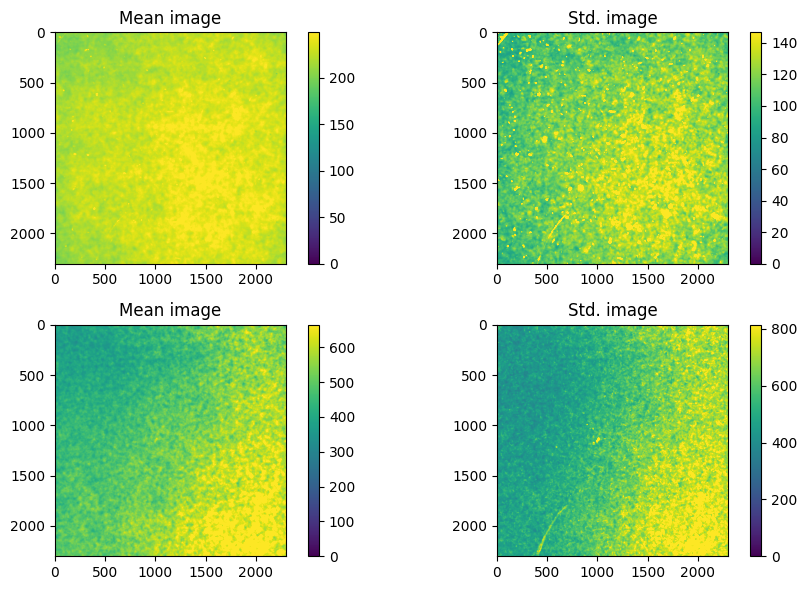

In [14]:
illumination_correction.plot()

In [15]:
raw = AICSImage(image_files[102], reader=readers.ome_tiff_reader.OmeTiffReader)
corrected = illumination_correction.correct(raw)

In [16]:
#illumination_correction.mean_image.get_image_data("YX", C=1, Z=0, T=0)
illumination_correction.mean_mean_image

[229.37834062804532, 519.5818789510806]

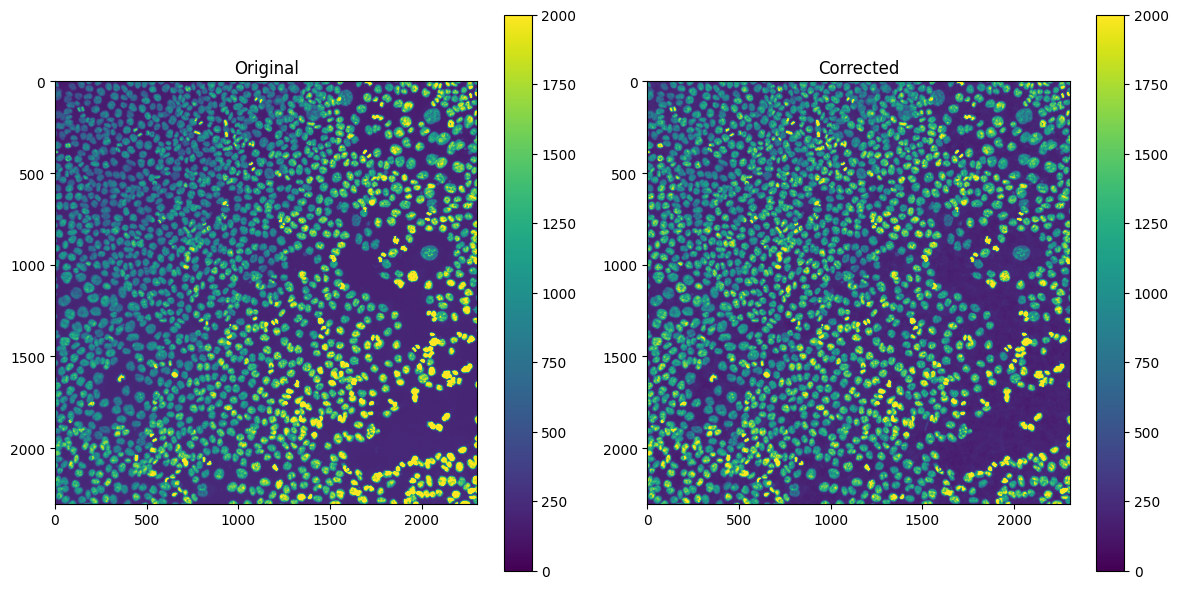

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im = axes[0].imshow(raw.get_image_data('YX',C=1,T=0), vmin=0, vmax=2000)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(corrected.get_image_data('YX',C=1,T=0), vmin=0, vmax=2000)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

In [21]:
corrected.channel_names

['647', '405']